In [37]:
!pip install pydicom pillow pylibjpeg-libjpeg pylibjpeg python-gdcm seaborn matplotlib SciPy scikit-image python-magic plotly pip install opencv-python 

 

     |████████████████████████████████| 46.4 MB 8.5 MB/s eta 0:00:012   |████▌                           | 6.5 MB 2.4 MB/s eta 0:00:17


In [38]:
#%reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
import pandas as pd
import cv2

In [12]:
ls

rnsa_cnn_init.ipynb               test_images/
rsna-breast-cancer-detection.zip  train.csv
sample_submission.csv             train_images/
test.csv                          workspace/


In [17]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [18]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [10]:
train_df["patient_id"].nunique()

11913

In [11]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


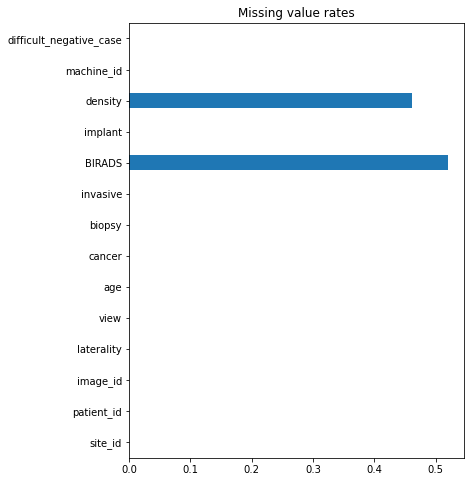

In [73]:
plt.figure(figsize=(6, 8))
train_df.isna().mean().plot(kind="barh")
plt.title("Missing value rates");

In [12]:
test_df.nunique()

site_id          1
patient_id       1
image_id         4
laterality       2
view             2
age              1
implant          1
machine_id       1
prediction_id    2
dtype: int64

In [21]:
train_images = glob("train_images/*/*.dcm")
len(train_images)

54706

In [22]:
train_images[0]

'train_images/1069/1313414003.dcm'

In [23]:
train_image0 = pydicom.read_file(train_images[0])
print(train_image0)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184021.071147'
(0010, 0020) Patient ID                          LO: '1069'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.1069
(0020, 000e) Series Instance UID

In [24]:
train_image0_array = train_image0.pixel_array

In [25]:
print(train_image0_array)

[[1784 1760 1686 ...    0    0    0]
 [1687 1754 1732 ...    0    0    0]
 [1682 1687 1736 ...    0    0    0]
 ...
 [1040 1043 1044 ...    0    0    0]
 [1034 1041 1059 ...    0    0    0]
 [1070 1059 1070 ...    0    0    0]]


In [28]:
print(train_image0_array.shape)

(2776, 2082)


0
2342


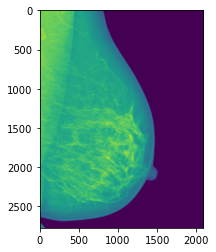

In [32]:
plt.imshow(train_image0_array)
print(train_image0_array.min())
print(train_image0_array.max())

In [60]:
# cf https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606
# Five steps of preprocessing: 
# Transforming to HU, Removing Noises, Tilt Correction, Crop Images and Padding.
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [89]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    window_center = medical_image.WindowCenter[0]
    window_width = medical_image.WindowWidth[0]
    windowed_image = window_image(hu_image, window_center, window_width) 
    
    segmentation = morphology.dilation(windowed_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image
    return masked_image

In [46]:
# for tilt correction
# not sure if it is useful for breast cancer as the original data is for brain ct
# tbd

In [47]:
def crop_image(image, display = False):
    mask = image == 0
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis = 1)
    bottom_right = np.max(coords, axis = 1)
    cropped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return cropped_image

In [48]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [90]:
hu_image = transform_to_hu( train_image0, train_image0_array)
window_image(hu_image, train_image0.WindowCenter, train_image0.WindowWidth)

array([[1784., 1760., 1686., ...,  893.,  893.,  893.],
       [1687., 1754., 1732., ...,  893.,  893.,  893.],
       [1682., 1687., 1736., ...,  893.,  893.,  893.],
       ...,
       [1040., 1043., 1044., ...,  893.,  893.,  893.],
       [1034., 1041., 1059., ...,  893.,  893.,  893.],
       [1070., 1059., 1070., ...,  893.,  893.,  893.]])

In [91]:
#file_path = "train_images/10006/1459541791.dcm"
remove_noise("train_images/10006/1459541791.dcm", display = True)

NameError: name 'ndimage' is not defined